In [1]:
!pip3 install pymc
!pip3 install arviz

In [2]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Step 0: Set the random seed for reproducibility
np.random.seed(42)

# Step 1: Generate synthetic "true" parameters for each person
P = 300  # number of participants
days_per_person = 14  # number of days for each person
N = P * days_per_person  # total number of datapoints

# Create dayIndex: repeated measurements for each person, e.g., [1, 2, 3, 4, ..., 1, 2, 3, 4]
dayIndex = np.tile(np.arange(0, days_per_person), P)

# Create nrAssess: number of assessments for each day
nrAssess = np.random.randint(1, 6, size=N)

# Create personIndex: person identifiers, e.g., [1, 1, 1, 1, ..., 10, 10, 10, 10]
personIndex = np.repeat(np.arange(P), days_per_person)

# True parameters
true_murC = 0.5
true_mugC = 2.0
true_muA = 1.0
true_muSdE = 0.2

true_rCSd = 0.1
true_gCSd = 0.5
true_aSd = 0.3
true_sdESd = 0.1

# Generate person-specific true parameters from the hyperpriors
true_rC = np.abs(np.random.normal(true_murC, true_rCSd, P))
true_gC = np.abs(np.random.normal(true_mugC, true_gCSd, P))
true_a = np.abs(np.random.normal(true_muA, true_aSd, P))
true_sdE = np.abs(np.random.normal(true_muSdE, true_sdESd, P))

# Step 2: Simulate RT data based on the true parameters
RT = np.zeros(N)
for n in range(N):
    person = personIndex[n]
    RT[n] = np.random.normal(true_a[person] + true_gC[person] * np.exp(-true_rC[person] * dayIndex[n]),
                             true_sdE[person]/math.sqrt(nrAssess[n]))

In [4]:
RT

array([3.00641183, 2.39883521, 2.35186496, ..., 0.81352336, 1.14885063,
       0.91261977])

In [5]:
# Step 3: Fit the PyMC model to this simulated data

# Save the start time
start_time = time.time()

with pm.Model() as model:

    # Hyperpriors
    murC = pm.HalfNormal("murC", sigma=1)
    mugC = pm.HalfNormal("mugC", sigma=1)
    muA = pm.HalfNormal("muA", sigma=1)
    muSdE = pm.HalfNormal("muSdE", sigma=1)

    rCSd = pm.HalfNormal("rCSd", sigma=1)
    gCSd = pm.HalfNormal("gCSd", sigma=1)
    aSd = pm.HalfNormal("aSd", sigma=1)
    sdESd = pm.HalfNormal("sdESd", sigma=1)

    # Person-specific parameters
    rC = pm.TruncatedNormal("rC", mu=murC, sigma=rCSd, lower=0, shape=P)
    gC = pm.TruncatedNormal("gC", mu=mugC, sigma=gCSd, lower=0, shape=P)
    a = pm.TruncatedNormal("a", mu=muA, sigma=aSd, lower=0, shape=P)
    sdE = pm.TruncatedNormal("sdE", mu=muSdE, sigma=sdESd, lower=0, shape=P)

    # Likelihood
    RT_obs = pm.Normal(
            "RT_obs",
            mu=a[personIndex] + gC[personIndex] * pm.math.exp(-rC[personIndex] * dayIndex),
            sigma=sdE[personIndex]/np.sqrt(nrAssess),
            observed=RT
        )

    # Sampling
    trace = pm.sample(draws=2000, chains=2, cores=2, return_inferencedata=True, random_seed = 123)

# Save the end time
end_time = time.time()

# Calculate the time difference
time_diff = (end_time - start_time) / 60
print(f"Time taken: {time_diff:.2f} minutes")

#draws: Number of posterior samples. The default is 1000.
#chains: Number of MCMC chains. The default is 4.
#tune: Number of adaptation steps. The default is 1000.
#target_accept: Target acceptance rate for the sampling algorithm. Used for controlling the step size. The default is 0.8.
#return_inferencedata: If set to True, the samples will be returned as an arviz.InferenceData object, which is useful for visualization and analysis. The default is False.
#init: Initialization method for the MCMC sampling. Options include 'auto', 'adapt_diag', 'adapt_dense', and 'random'. The default is 'auto', which automatically selects the best method.
#progressbar: If set to True, shows a progress bar during sampling. The default is True.
#include_tuned: If set to True, includes tuned samples in the output. The default is False.
#model: The model object to sample from. If not specified, it defaults to the currently active model.
#random_seed: Seed for the random number generator, allowing for reproducibility of results.
#return_coords: If set to True, the returned samples will include coordinates for each parameter. The default is False.
#trace: If set to True, saves the posterior samples in the model's trace attribute for later access. The default is True.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [murC, mugC, muA, muSdE, rCSd, gCSd, aSd, sdESd, rC, gC, a, sdE]


/Users/nur375/Documents/GitHub/cascadelab-pymc-fastapi-demo/fastapi_pymc_env/lib/python3.12/site-packages/rich/live
.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 42 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Time taken: 1.39 minutes


In [6]:
# Check estimation results (e.g., mean, standard deviation, credible interval, ESS, Rhat)
summary = az.summary(trace)

# Add columns for true values, bias, and relative bias
# Step 1: Create a DataFrame for true population parameters
true_values = {
    "murC": true_murC,
    "mugC": true_mugC,
    "muA": true_muA,
    "muSdE": true_muSdE,
    "rCSd": true_rCSd,
    "gCSd": true_gCSd,
    "aSd": true_aSd,
    "sdESd": true_sdESd
}

true_values_df1 = pd.DataFrame(list(true_values.items()), columns=['parameter', 'true'])


# Step 2: Create a DataFrame for person-specific parameters
params = {
    'rC': true_rC,
    'gC': true_gC,
    'a': true_a,
    'sdE': true_sdE
}

true_values_df2 = pd.concat(
    [pd.DataFrame({'parameter': [f"{param}[{i}]" for i in range(P)], 'true': values})
     for param, values in params.items()],
    ignore_index=True
)

true_values_df = pd.concat([true_values_df1, true_values_df2], ignore_index=True)
true_values_df = round(true_values_df, 3)

# Step 3: Merge them
summary = summary.reset_index().rename(columns={'index': 'parameter'})
summary_new = summary.merge(true_values_df, on='parameter', how='left')
# Calculate bias and relative bias
summary_new['bias'] = summary_new['mean'] - summary_new['true']
summary_new['relative_bias'] = round(summary_new['bias'] / summary_new['true'], 3)

# print out the final result table
print(summary_new)

# write to csv files
#import os
#os.chdir('/content/drive/MyDrive/Colab Notebooks/EAS')
summary_new.to_csv('resulttable.csv', index = False)


     parameter   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
0         murC  0.505  0.007   0.492    0.518      0.000    0.000    3591.0   
1         mugC  1.943  0.028   1.889    1.994      0.000    0.000    7469.0   
2          muA  0.984  0.018   0.949    1.018      0.000    0.000    7274.0   
3        muSdE  0.202  0.007   0.189    0.214      0.000    0.000    4944.0   
4         rCSd  0.098  0.006   0.087    0.109      0.000    0.000    2115.0   
...        ...    ...    ...     ...      ...        ...      ...       ...   
1203  sdE[295]  0.434  0.051   0.344    0.531      0.001    0.001    5308.0   
1204  sdE[296]  0.223  0.042   0.149    0.303      0.001    0.000    5499.0   
1205  sdE[297]  0.249  0.044   0.167    0.328      0.001    0.000    6182.0   
1206  sdE[298]  0.429  0.049   0.343    0.523      0.001    0.000    5685.0   
1207  sdE[299]  0.272  0.047   0.190    0.358      0.001    0.000    5603.0   

      ess_tail  r_hat   true   bias  relative_bias 

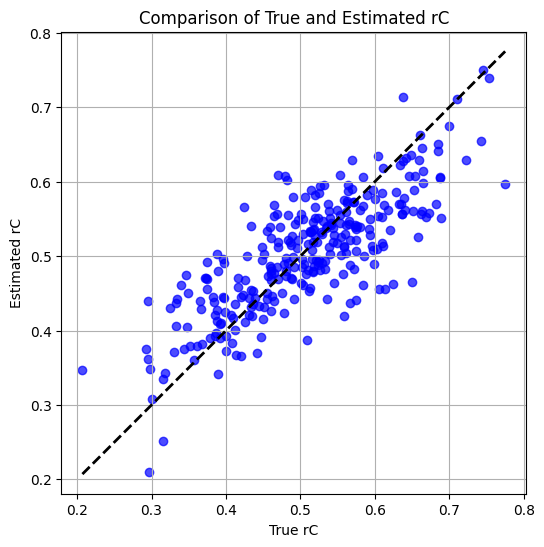

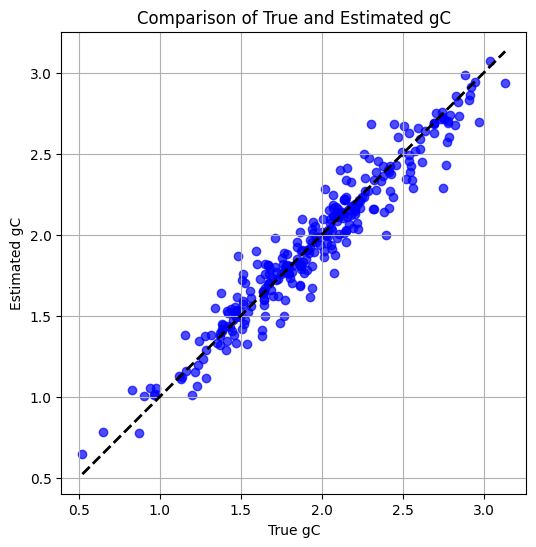

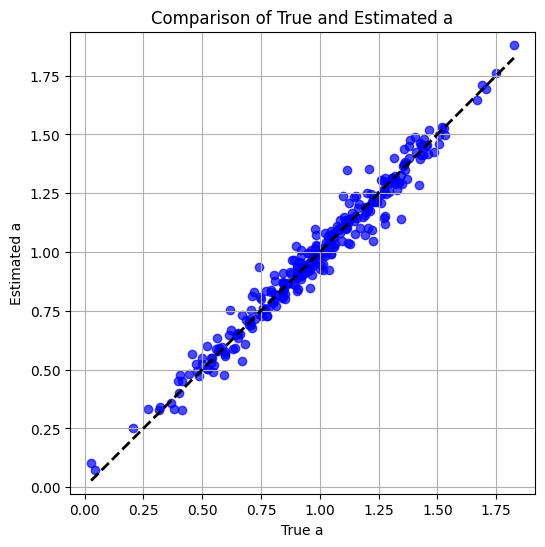

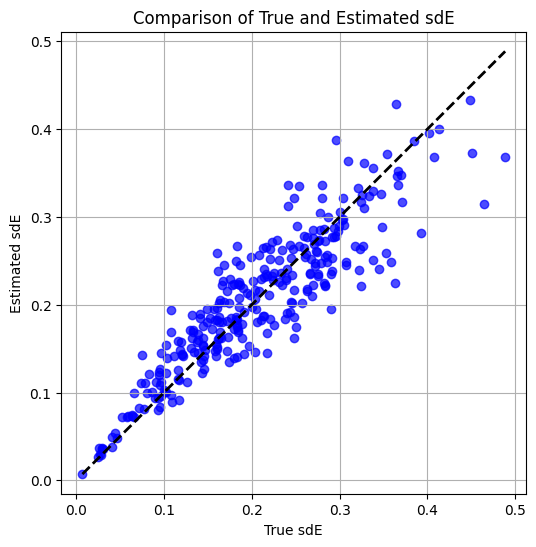

In [7]:
# scatter plot of true and estimated person-specific parameters
def plot_parameter_comparison(true_params, estimated_params, param_name):
    """
    Create a scatter plot to compare true and estimated parameters.

    Parameters:
    - true_params: array-like, true parameter values.
    - estimated_params: array-like, estimated parameter values from the model.
    - param_name: str, name of the parameter for plot labeling.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(true_params, estimated_params, color='blue', alpha=0.7)
    plt.plot([true_params.min(), true_params.max()], [true_params.min(), true_params.max()], 'k--', lw=2)  # Identity line
    plt.title(f'Comparison of True and Estimated {param_name}')
    plt.xlabel(f'True {param_name}')
    plt.ylabel(f'Estimated {param_name}')
    plt.grid()
    plt.axis('equal')  # Ensure equal scaling
    plt.show()


# get the estimates by calculating the means of posterior samples
rC_estimated = trace.posterior['rC'].mean(dim=['chain','draw']).values.flatten()  # Estimated rC
gC_estimated = trace.posterior['gC'].mean(dim=['chain','draw']).values.flatten()  # Estimated gC
a_estimated = trace.posterior['a'].mean(dim=['chain','draw']).values.flatten()  # Estimated a
sdE_estimated = trace.posterior['sdE'].mean(dim=['chain','draw']).values.flatten()  # Estimated sdE

# use the function to create scatter plots
plot_parameter_comparison(true_rC, rC_estimated, 'rC')
plot_parameter_comparison(true_gC, gC_estimated, 'gC')
plot_parameter_comparison(true_a, a_estimated, 'a')
plot_parameter_comparison(true_sdE, sdE_estimated, 'sdE')
